In [1]:
import numpy as np
import pandas as pd
import re
import emoji
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import keras_tuner as kt

from keras.models import Sequential
from keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, Dense, LSTM, SpatialDropout1D, Flatten

from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from langdetect import detect

import language_tool_python as lang_tool
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from readability import Readability

c:\Users\molaf\miniconda3\envs\coursework\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\molaf\miniconda3\envs\coursework\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an 

## Data Analysis: dataset exploration and class bias

<bound method DataFrame.info of                   tweetId                                          tweetText  \
0      263046056240115712  ¿Se acuerdan de la película: “El día después d...   
1      262995061304852481  @milenagimon: Miren a Sandy en NY!  Tremenda i...   
2      262979898002534400  Buena la foto del Huracán Sandy, me recuerda a...   
3      262996108400271360     Scary shit #hurricane #NY http://t.co/e4JLBUfH   
4      263018881839411200  My fave place in the world #nyc #hurricane #sa...   
...                   ...                                                ...   
14272  443231991593304064  @BobombDom *slaps TweetDeck with the PigFish h...   
14273  443086239127076865  New Species of Fish found in Brazil or just Re...   
14274  442978105238753280  What do we call this? #pigFISH http: \/\/t.co\...   
14275  442753479782989824  Pigfish ? E dopo il pescecane c'è il pesce mai...   
14276  442700377860104192  For those who can't decide between fish or mea...   

       

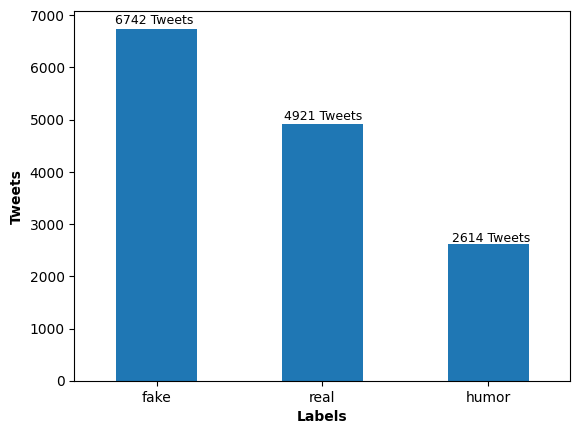

In [2]:
training = pd.read_csv('mediaeval-2015-trainingset.txt', sep="\t")
test = pd.read_csv('mediaeval-2015-testset.txt', sep="\t")

print(training.info)
print(test.info)

print("Number of Labels in the Training DataSet {}".format(training['label'].value_counts()))
print("Number of Labels in the Test DataSet {}".format(test['label'].value_counts()))

bar = training['label'].value_counts().plot.bar(width=0.49)
bar.set_xlabel('Labels', weight='bold')
bar.set_ylabel('Tweets', weight='bold')
bar.set_xticklabels(bar.get_xticklabels(), rotation=0)

for p in bar.patches:
    bar.annotate(str(p.get_height()) + " Tweets", (p.get_x() * 1.015, p.get_height() * 1.015), fontsize=9)
plt.savefig('graphs/tweets_labels.jpeg', bbox_inches='tight')

# Drop the humor class
training = training[training.label != 'humor']

##  Data Analysis: Number of users that has more than one tweet

In [3]:
print("Number of duplicate UserIds in the Training Set is {}. Total Number of Tweets is {}".format(
    training.duplicated(subset=["userId"], keep=False).value_counts()[True], len(training)))
print("Number of duplicate UserIds in the Test Set is {}. Total Number of Tweets is {}".format(
    test.duplicated(subset=["userId"], keep=False).value_counts()[True], len(test)))

Number of duplicate UserIds in the Training Set is 1066. Total Number of Tweets is 11663
Number of duplicate UserIds in the Test Set is 339. Total Number of Tweets is 3755


## Helper functions for Data Analysis

In [3]:
# Regex pattrens for text cleaning
user_pattern = "@\w+"
id_pattern = "([0-9])\d{6,}"
hashtag_pattern = "#\w+"
link_pattern = "http(s)?://[^\s]+"
punctuations1_pattern = "\[.*?\]"
punctuations2_pattern = "\[.*?\]"
random_pattern = "[^a-z0-9]"

stoplist = stopwords.words('english')
stoplist.extend([',', ':',"?", "!", "[", "]", "(", ")", "..." , ";", "¿", "!", ".", "\\\\", "-", "_"])

tknzr = TweetTokenizer()
sntmnt = SentimentIntensityAnalyzer()
grammar = lang_tool.LanguageTool('en-US')

# Change Labels to Numeric Values
def labelToNumeric(data):    
    data.loc[data['label'] == 'humor', 'label'] = 1
    data.loc[data['label'] == 'fake', 'label'] = 1
    data.loc[data['label'] == 'real', 'label'] = 0

# Detect the Language of Each Tweet
def findLang(data):
    langs = []
    for tweet in data["tweetText"]:
        try:
            lang = detect(tweet)
        except:
            ## some tweets will have excessive number of emojis
            lang = detect(tweet[:20])
            
        langs.append(lang)

    data["lang"] = langs

# Limit the tweet to 140 words 
def tweetLimit(tweet):
    if len(tweet) > 140:
        pos = re.search(id_pattern, tweet)
        if pos:
            return tweet[:pos.start(1)]
        else:
            return tweet[:140]
    else:
        return tweet

# Tweet Length function
def tweet_length(tweet):
    return len(tweet)

# Number of hashtags within a tweet
def hashtags_num(tweet):
    num = re.findall(hashtag_pattern, tweet)
    return len(num)

# Number of grammatical mistakes within a tweet
def mistakes_num(tweet):
    return len(grammar.check(tweet))
        
# Number of links within a tweet
def links_num(tweet):
    urls = re.findall(link_pattern, tweet)
    return len(urls)

# Number of emojis within a tweet
def emojis_num(tweet):
    return emoji.emoji_count(tweet)

# Snetiment compound score
def sentiment_analysis(tweet):
    return sntmnt.polarity_scores(tweet)['compound']

## Sentiment Classes, Positive, Neutral or Negative
def three_sentiments(sent_value):
    if sent_value > 0:
        return 1
    elif sent_value < 0:
        return -1
    else:
        return 0

# Filtering the topics
def topic(imageid):
    return imageid.split("_")[0]

# Unused! Readibility test
def readibility(tweet):
    r = Readability(tweet)
    try:
        return r.ari().score
    except:
        return 0

# Replace all emojis with an emoji string
def clean_emoji(tweet):
    return emoji.replace_emoji(tweet, "emoji")

# Replace all users with a user string
def clean_user(tweet):
    return re.sub(user_pattern, "user", tweet)

# remove random pattrens
def clean_random(tweet):
    return re.sub(random_pattern, " ", tweet)
    
# replace hashtags with an empty string
def clean_hashtag(tweet):
    return re.sub(hashtag_pattern, " ", tweet)

# replace links with an empty string
def clean_link(tweet):
    return re.sub(link_pattern, " ", tweet)

# clean punctations
def clean_stop_word(tweet):
    tweet = re.sub(punctuations2_pattern, " ", tweet)
    tweet = re.sub(punctuations1_pattern, " ", tweet)
    return tweet

# Apply all cleaning functions
def clean_all(tweet):
    tweet = clean_emoji(tweet)
    tweet = clean_hashtag(tweet)
    tweet = clean_link(tweet)
    tweet = clean_user(tweet)
    tweet = clean_stop_word(tweet)
    tweet = tweet.lower()
    tweet = clean_random(tweet)
    tweet = tknzr.tokenize(tweet)
    return tweet

# Find the language of every tweet
findLang(training)
findLang(test)

## Data Analysis: Tweets Language

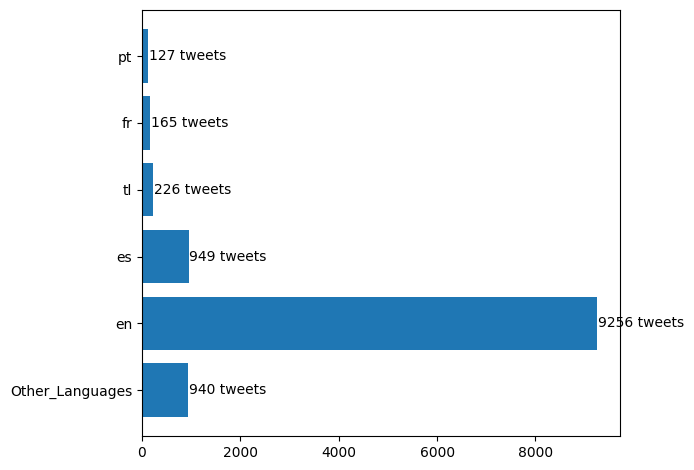

In [5]:
### Comparison Of Languages within the tweets 
tweetLang = training['lang'].value_counts().to_dict()

## Add other languages class
tweetLang_training = dict()
tweetLang_training['Other_Languages'] = 0

# Add languages with a value less than or equal to 100 to the other class
for language, value in tweetLang.items():
    if value <= 100:
        tweetLang_training['Other_Languages'] += value
    else:
        tweetLang_training[language] = value

# Plot the languages
fig, ax = plt.subplots()

bars = ax.barh(range(len(tweetLang_training)), tweetLang_training.values(), align='center')
# ax.invert_yaxis()
ax.set_yticks(range(len(tweetLang_training)), labels=tweetLang_training.keys())
plt.tight_layout()
# ax.bar_label(bars)
plt.bar_label(bars, padding= 0.5, fmt='%g tweets', label_type='edge')

# fig.set_size_inches(7, 7.5)
plt.savefig('graphs/training_lang.png', bbox_inches='tight')

## Data Analysis: News Topics for English tweets

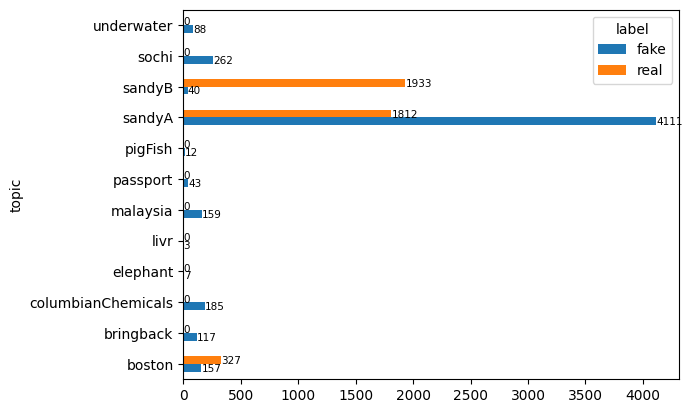

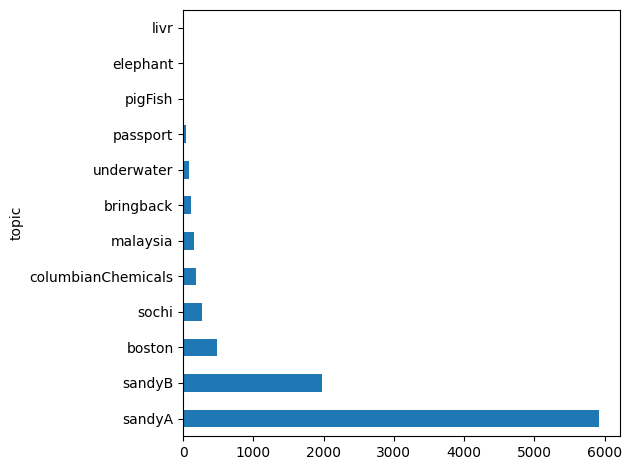

In [9]:
# Only keep the English Tweets
training = training[training.lang == 'en']

# Comparison of topics within the DataSet as a function of labels
training['topic'] = training['imageId(s)'].apply(topic)
label_topics = training.groupby('topic')['label'].value_counts().unstack().fillna(0)

## Count number of occurences
topics = training['topic'].value_counts()

barh = label_topics.plot(kind='barh')
# Annotations on the bars for the values
for p in barh.patches:
    barh.annotate(str(int(p.get_width())), (p.get_width() * 1.001, p.get_y() * 1.001), fontsize=7.5)

plt.savefig('graphs/topics_labels.png', bbox_inches='tight')
plt.show()


# Comparison of topics occurences
bars = topics.plot(kind='barh')
ax.set_yticks(range(len(topics)), labels=topics.keys())
plt.tight_layout()
# ax.bar_label(bars)
# plt.bar_label(bars, padding= 1)

plt.savefig('graphs/training_topics.png', bbox_inches='tight')
plt.show()

## Data Cleaning: Filtering Tweets topics with less than 100 occurences

In [10]:
# Filter the topics that has less than a 100 examples

training['topic'] = training['imageId(s)'].apply(topic)
topics = training['topic'].value_counts()

keep = topics[topics > 100].index

training = training[training['topic'].isin(keep)]

print(training['topic'].value_counts())

# Filter the languages that has less than a 100 examples. UNUSED 

# lans = training['lang'].value_counts()
# keep = lans[lans > 100].index
# training = training[training['lang'].isin(keep)]
# print(training['lang'].value_counts())

topic
sandyA                5923
sandyB                1973
boston                 484
sochi                  262
columbianChemicals     185
malaysia               159
bringback              117
Name: count, dtype: int64


## Data Cleaning: Applying all helper functions to the training and test dataset

In [11]:
## Training Dataset

# Only keep the English Tweets
training = training[training.lang == 'en']

training['grammar'] = training['tweetText'].apply(mistakes_num)
training['tweetText'] = training['tweetText'].apply(tweetLimit)
training['tweetLength'] = training['tweetText'].apply(tweet_length)
training['links'] = training['tweetText'].apply(links_num)
training['hashtags'] = training['tweetText'].apply(hashtags_num)
training['emoji'] = training['tweetText'].apply(emojis_num)
training['sentiment'] = training['tweetText'].apply(sentiment_analysis)
training['topic'] = training['imageId(s)'].apply(topic)
training['filteredTweet'] = training['tweetText'].apply(clean_all)

# Test Dataset
test['grammar'] = test['tweetText'].apply(mistakes_num)
test['tweetText'] = test['tweetText'].apply(tweetLimit)
test['tweetLength'] = test['tweetText'].apply(tweet_length)
test['links'] = test['tweetText'].apply(links_num)
test['hashtags'] = test['tweetText'].apply(hashtags_num)
test['emoji'] = test['tweetText'].apply(emojis_num)
test['sentiment'] = test['tweetText'].apply(sentiment_analysis)
test['topic'] = test['imageId(s)'].apply(topic)
test['filteredTweet'] = test['tweetText'].apply(clean_all)

# Change labels from strings to numerics
labelToNumeric(test)
labelToNumeric(training)

# Analyse the occurences of emojis, hashtags and links as a function of the labels 
emoji_only = training[training.emoji > 0]
hashtags_only = training[training.hashtags > 0]
links_only = training[training.links > 0]
print("Emojis only {}".format(emoji_only['label'].value_counts()))
print("Hashtags only {}".format(hashtags_only['label'].value_counts()))
print("Links only {}".format(links_only['label'].value_counts()))
print("Total number {}".format(training['label'].value_counts()))

Emojis only label
1    381
0    140
Name: count, dtype: int64
Hashtags only label
1    3455
0    3356
Name: count, dtype: int64
Links only label
1    5031
0    4071
Name: count, dtype: int64
Total number label
1    5031
0    4072
Name: count, dtype: int64


## Data Analysis: Plotting histograms for occurences of emojis, links and hashtags

    emoji label
0       0     1
1       0     1
2       0     0
3       0     1
4       0     0
..    ...   ...
95      0     0
96      0     0
97      0     1
98      0     0
99      0     0

[100 rows x 2 columns]


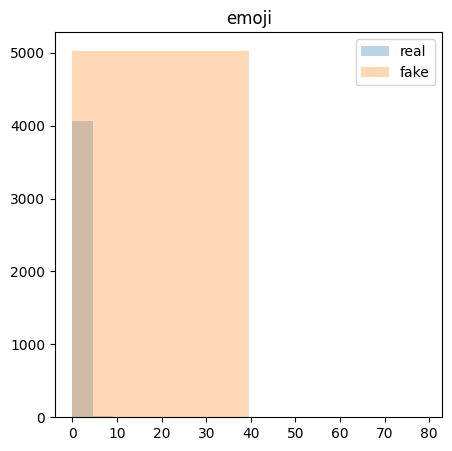

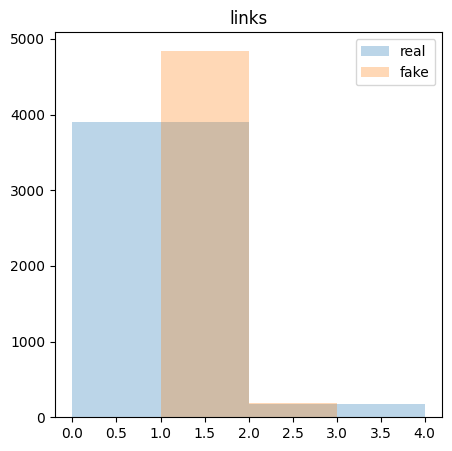

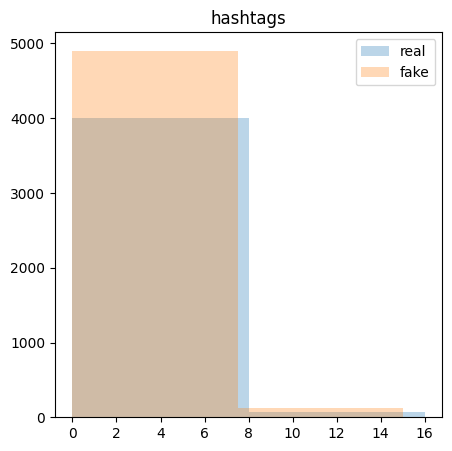

In [34]:
emoji = training[['emoji', "label"]]
link = training[['links', "label"]]
hashtag = training[['hashtags', "label"]]

all_comp = [emoji, link, hashtag]
types = ['emoji', 'links', 'hashtags']

for frame, t in zip(all_comp, types):
    real = frame[frame['label'] == 0]
    fake = frame[frame['label'] == 1]

    # Plot histograms
    plt.figure(figsize=(5, 5))
    plt.hist(real[t], bins=2, alpha=0.3, label='real')
    plt.hist(fake[t], bins=2, alpha=0.3, label='fake')

    plt.title(t)
    plt.legend()
    plt.savefig('graphs/distribution_{}.png'.format(t), bbox_inches='tight')
    plt.show()

## Data Analysis: Plotting histogram for sentiment values distribution as a function of labels

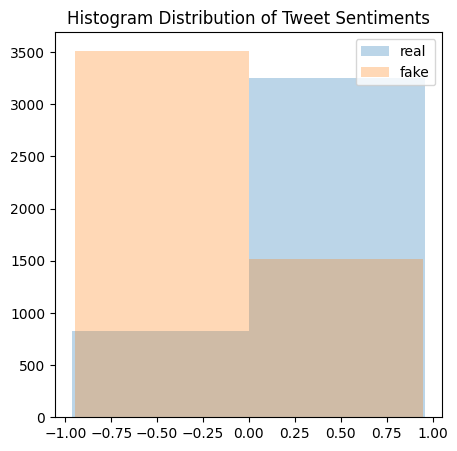

In [35]:
sentiment = training[['sentiment', "label"]]

real = sentiment[sentiment['label'] == 0]
fake = sentiment[sentiment['label'] == 1]

# Plot histograms
plt.figure(figsize=(5, 5))
plt.hist(real["sentiment"], bins=2, alpha=0.3, label='real')
plt.hist(fake["sentiment"], bins=2, alpha=0.3, label='fake')

plt.title("Histogram Distribution of Tweet Sentiments")
plt.legend()
plt.savefig('graphs/distribution_{}.png'.format("sentiment"), bbox_inches='tight')
plt.show()

## Data Analysis: Final Value counts for labels. 

A more balanced class has been made after data cleaning.

label
1    5031
0    4072
Name: count, dtype: int64


<Axes: xlabel='label'>

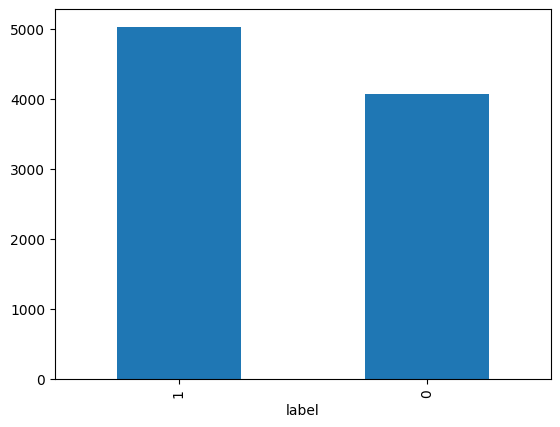

In [14]:
print(training['label'].value_counts())
training['label'].value_counts().plot.bar()

## Accuracy Scores: Confusion_matrix and F1-Score

In [6]:
# Confusion Matrix
def confusion_matrix(y_true, y_pred):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    
    for true, pred in zip(y_true, y_pred):
        if true == pred == 1:
            tp += 1
        elif true == pred == 0:
            tn += 1
        elif (true == 0) and pred == 1:
            fp += 1
        elif (true == 1) and pred == 0:
            fn += 1
    
    try:
        precision = tp / (tp + fp)

        recall = tp / (tp + fn)
        
    except ZeroDivisionError:
        recall = precision = 0
    
    return precision, recall

# F-1 Score
def f1_score(precision, recall):
    
    if precision == 0 or recall == 0:
        return 0
    
    return 2 * ((precision * recall) / (precision + recall))

## Keras Callback function to evaluate precision, recall and F1-score during training

Code has been adapted from:
https://stackoverflow.com/questions/52285501/how-can-i-create-a-custom-callback-in-keras

In [16]:
# Call back to calculate the f-1 Score
class F1History(tf.keras.callbacks.Callback):

    def __init__(self, train, validation=None, threshold=0.5):
        super(F1History, self).__init__()
        self.validation = validation
        self.train = train
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs={}):

        logs['F1_score_train'] = float('-inf')
        X_train, y_train = self.train[0], self.train[1]
        y_pred = (self.model.predict(X_train).ravel()>self.threshold)+0
        precision, recall = confusion_matrix(y_train, y_pred)
        score = f1_score(precision, recall)       
        logs['F1_score_train'] = np.round(score, 5)
        logs['Precision'] = np.round(precision, 5)
        logs['Recall'] = np.round(recall, 5)
        
        if (self.validation):
            logs['F1_score_val'] = float('-inf')
            X_valid, y_valid = self.validation[0], self.validation[1]
            y_val_pred = (self.model.predict(X_valid).ravel()>self.threshold)+0
            val_precision, val_recall = confusion_matrix(y_valid, y_val_pred)
            val_score = f1_score(val_precision, val_recall)
            logs['F1_score_val'] = np.round(val_score, 5)
            logs['Precision_val'] = np.round(val_precision, 5)
            logs['Recall_val'] = np.round(val_recall, 5)
            

## Pipeline design 1 - Embedding-LSTM-Dense

In [17]:
# Shuffle the dataset
training = training.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

# Set the max length to the maximum Tweet length limit
max_len = 140  # Sequence length to pad the outputs to.

# Create a list of all vocabularies
text_dataset = [t for tweet in training['filteredTweet'] for t in tweet]
train_text = [t for t in training['filteredTweet']]
test_text = [t for t in test['filteredTweet']]

# Fit the text on the tokenizer and transform the training and test text
toknizer = Tokenizer()
toknizer.fit_on_texts(text_dataset)

# Convert the training and test sets into sequences
train_sequences = toknizer.texts_to_sequences(train_text)
test_sequences = toknizer.texts_to_sequences(test_text)

# Pad the sequences with the maximum limit to ensure that sequences are the same size
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_len)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_len)

# Convert labels into tensors
y_train = np.asarray(training['label']).astype(np.int32)
y_test = np.asarray(test['label']).astype(np.float32)

# Convert training sequences dataframes into a tensors
x_train = tf.convert_to_tensor(padded_train_sequences, dtype=tf.float64)
x_test = tf.convert_to_tensor(padded_test_sequences, dtype=tf.float64)

In [18]:
# Model build function for Keras-HyperTuner
def build_model(hp):
    sequence_length = max_len

    # All hyper tuner values
    dense_activations = hp.Choice('activation', values=['relu', 'tanh', 'softmax'])
    hp_embedding_size = hp.Choice('embeds', values= [4, 8, 16, 32, 64])
    hp_lr = hp.Choice('lr', values= [0.01, 0.001, 0.0001])
    hp_vocab_size = hp.Int('vocab', min_value=1000, max_value= 20000, step=50)
    hp_dropout_values = hp.Float('dropout', min_value = 0.05, max_value = 0.7, step = 0.05)
    hp_f1_threshold = hp.Float('F1_Threshold', min_value= 0.1, max_value= 0.4, step = 0.1)


    model = Sequential()
    # Embedding layer
    model.add(Embedding(input_dim=hp_vocab_size, output_dim=hp_embedding_size, input_length=sequence_length))
    # Spatial Dropout for regularisation
    model.add(SpatialDropout1D(hp_dropout_values))

    model.add(LSTM(units=hp_embedding_size, return_sequences=True))
    
    # Flatten hidden vector for Dense layer
    model.add(Flatten())

    model.add(Dense(hp_embedding_size*2, activation=dense_activations))

    model.add(Dense(1, activation='sigmoid'))

    # Helper functions 
    opt = tf.keras.optimizers.Adam(learning_rate = hp_lr)
    f1 = tfa.metrics.F1Score(num_classes= 1, threshold=hp_f1_threshold)

    model.compile(
        loss = 'binary_crossentropy',
        optimizer = opt,
        metrics= [f1]
    )

    return model

In [19]:
# Class weights, unsed as data cleaning has balanced the the labels

# Computing class weights for the imbalanced data
class_weights = compute_class_weight( class_weight= "balanced", classes=[0,1] , y=y_train)
class_weights = {0 : class_weights[0], 1:class_weights[1]}

print(class_weights)

{0: 1.1177554027504912, 1: 0.9046909163188233}


In [36]:
# Reduce the loss on a plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.9, patience=2)

'''
Hyper Parameter Tuning 

Main Objective is to Maximise the F1-Score
Maximum epochs are set to 5 to prevent overfitting
'''
tune = kt.Hyperband(build_model, 
                    objective=kt.Objective('f1_score', direction='max'),
                    max_epochs = 5,
                    factor = 80,
                    hyperband_iterations=20,
                    directory='final',
                    project_name='comp')

# Validation Split is 0.2
tune.search(x_train, y_train, epochs=400, validation_split=0.20, callbacks=[reduce_lr])

Trial 40 Complete [00h 00m 22s]
f1_score: 0.7279624342918396

Best f1_score So Far: 0.9526978731155396
Total elapsed time: 00h 16m 31s


In [38]:
# Get the best hyperparameters
best_hps = tune.get_best_hyperparameters(num_trials=1)[0]

print("The best parameters are {}".format(best_hps.values))

# Build the model with the best hyperparameters
model = tune.hypermodel.build(best_hps)

# train the model
history = model.fit(x=x_train, y=y_train,
          epochs = 3,
          callbacks=[reduce_lr, F1History(train=(x_train[:int(len(x_train) * 0.8)], y_train[:int(len(x_train) * 0.8)]),
                             validation=(x_train[int(len(x_train) * 0.8):], y_train[:int(len(x_train) * 0.8)]), threshold=best_hps['F1_Threshold'])])
# class_weight=class_weights

# Evaluation
model.evaluate(x_test, y_test)

y_predict = model.predict(x_test)

# Round the prediction values based on the best f1-threshold score
y_predict_bool = np.where(y_predict > best_hps['F1_Threshold'], 1, 0)

precision, recall = confusion_matrix(y_test, y_predict_bool)

print("Precision is {} \nRecall is {}".format(precision, recall))

score = f1_score(precision, recall)
print("F-1 Score is {}".format(score))

The best parameters are {'activation': 'relu', 'embeds': 16, 'lr': 0.01, 'vocab': 16100, 'dropout': 0.15000000000000002, 'F1_Threshold': 0.30000000000000004, 'tuner/epochs': 5, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Epoch 1/3
285/285 [==============================] - 6s 18ms/step - loss: 0.4228 - f1_score: 0.8159 - lr: 0.0100 - F1_score_train: 0.8861 - Precision: 0.7973 - Recall: 0.9970 - F1_score_val: 0.6195 - Precision_val: 0.5599 - Recall_val: 0.6934
Epoch 2/3
285/285 [==============================] - 5s 17ms/step - loss: 0.2206 - f1_score: 0.9150 - lr: 0.0100 - F1_score_train: 0.9336 - Precision: 0.8792 - Recall: 0.9950 - F1_score_val: 0.5869 - Precision_val: 0.5546 - Recall_val: 0.6231
Epoch 3/3
118/118 [==============================] - 0s 4ms/step
Precision is 0.8926576217079011 
Recall is 0.8786331500392773
F-1 Score is 0.8855898653998416


{'loss': [0.42275574803352356, 0.2206449955701828, 0.16408506035804749], 'f1_score': [array([0.81593454], dtype=float32), array([0.91504717], dtype=float32), array([0.9365394], dtype=float32)], 'lr': [0.01, 0.01, 0.01], 'F1_score_train': [0.88605, 0.93357, 0.95158], 'Precision': [0.7973, 0.87925, 0.91031], 'Recall': [0.99702, 0.99504, 0.99678], 'F1_score_val': [0.61953, 0.58687, 0.57563], 'Precision_val': [0.5599, 0.55458, 0.55282], 'Recall_val': [0.69337, 0.62315, 0.6004]}


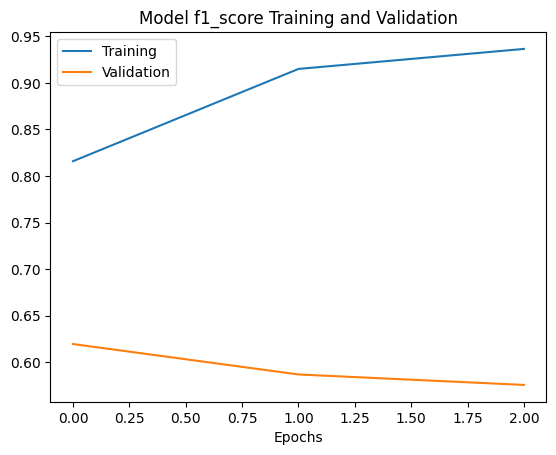

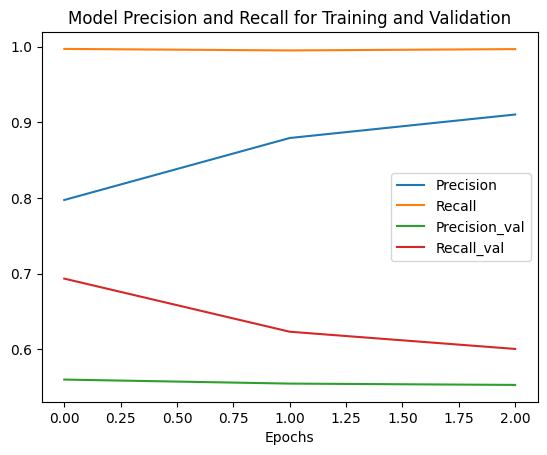

<Figure size 640x480 with 0 Axes>

In [43]:
print(history.history)
history_df = pd.DataFrame(history.history)
# Save the DataFrame to a CSV file
plt.plot(history_df['f1_score'])
plt.plot(history_df['F1_score_val'])
plt.title('Model f1_score Training and Validation')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper left')

plt.savefig("graphs/f1-score graph.png", bbox_inches='tight')
plt.show()

plt.plot(history_df['Precision'])
plt.plot(history_df['Recall'])
plt.plot(history_df['Precision_val'])
plt.plot(history_df['Recall_val'])
plt.title('Model Precision and Recall for Training and Validation')
plt.xlabel('Epochs')
plt.legend(['Precision', 'Recall', 'Precision_val', 'Recall_val'], loc='center right')

plt.savefig("graphs/precision_recall.png", bbox_inches='tight')
plt.show()

# PipeLine Design 2 - Adaboost Classifier

## Data Preprocessing

In [4]:
# Needs to be imported again due to an error
import emoji

# Number of emojis within a tweet
def emojis_num(tweet):
    return emoji.emoji_count(tweet)


# Extract the dataset again and remove humor label
training_ada = pd.read_csv('mediaeval-2015-trainingset.txt', sep="\t")
test_ada = pd.read_csv('mediaeval-2015-testset.txt', sep="\t")

# Drop the humor label
training_ada = training_ada[training_ada.label != 'humor']

# Find the tweet languages
findLang(training_ada)
findLang(test_ada)

# Only keep English Tweets
training_ada = training_ada[training_ada.lang == 'en']

training_ada['grammar'] = training_ada['tweetText'].apply(mistakes_num)
training_ada['tweetText'] = training_ada['tweetText'].apply(tweetLimit)
training_ada['tweetLength'] = training_ada['tweetText'].apply(tweet_length)
training_ada['emoji'] = training_ada['tweetText'].apply(emojis_num)
training_ada['links'] = training_ada['tweetText'].apply(links_num)
training_ada['hashtags'] = training_ada['tweetText'].apply(hashtags_num)
training_ada['sentiment'] = training_ada['tweetText'].apply(sentiment_analysis)
training_ada['sentiment'] = training_ada['sentiment'].apply(three_sentiments)
training_ada['topic'] = training_ada['imageId(s)'].apply(topic)

test_ada['grammar'] = test_ada['tweetText'].apply(mistakes_num)
test_ada['tweetText'] = test_ada['tweetText'].apply(tweetLimit)
test_ada['tweetLength'] = test_ada['tweetText'].apply(tweet_length)
test_ada['emoji'] = test_ada['tweetText'].apply(emojis_num)
test_ada['links'] = test_ada['tweetText'].apply(links_num)
test_ada['hashtags'] = test_ada['tweetText'].apply(hashtags_num)
test_ada['sentiment'] = test_ada['tweetText'].apply(sentiment_analysis)
test_ada['sentiment'] = test_ada['sentiment'].apply(three_sentiments)
test_ada['topic'] = test_ada['imageId(s)'].apply(topic)

labelToNumeric(training_ada)
labelToNumeric(test_ada)

topics  = {}
test_topics = {}

langs  = {}
test_langs = {}

# Extract News Topics and Languages
for i in training_ada['imageId(s)']:
    i = i.split("_")
    if i[0] not in topics:
        topics[i[0]] = 1
    else:
        topics[i[0]] += 1

for i in test_ada['imageId(s)']:
    i = i.split("_")
    if i[0] not in test_topics:
        test_topics[i[0]] = 1
    else:
        test_topics[i[0]] += 1

for i in training_ada['lang']:
    if i not in langs:
        langs[i] = 1
    else:
        langs[i] += 1

for i in test_ada['lang']:
    if i not in test_langs:
        test_langs[i] = 1
    else:
        test_langs[i] += 1


# Sort all occurences
for dictionary in [test_topics, topics, langs, test_langs]:
    dictionary = sorted(dictionary.items(), key=lambda item: item[1])

# Convert the Dictionaries into values
mapped_test = list(test_topics.keys())
mapped_topics = list(topics.keys())
mapped_langs  = list(langs.keys())
mapped_test_langs = list(test_langs.keys())


def topics_train_mapping(topic):
    return mapped_topics.index(topic)

def topics_test_mapping(topic):
    return mapped_test.index(topic)

def lang_train_mapping(lang):
    return mapped_langs.index(lang)

def lang_test_mapping(lang):
    return mapped_test_langs.index(lang)

forest_true = np.asarray(training_ada['label']).astype(np.int32)
forest_train = training_ada.drop(columns=[ "tweetText",  "imageId(s)","lang", "username", "label", "timestamp", "tweetId"])

forest_true_test = np.asarray(test_ada['label']).astype(np.int32)
forest_test = test_ada.drop(columns=["tweetText", "imageId(s)", "username", "lang", "label", "timestamp", "tweetId"])

# Apply indexing to the news topics
forest_train["topic"] = forest_train["topic"].apply(topics_train_mapping)
forest_test['topic'] = forest_test['topic'].apply(topics_test_mapping)

# Apply indexing to the languages unused after iterating
# forest_train["lang"] = forest_train["lang"].apply(lang_train_mapping)
# forest_test['lang'] = forest_test['lang'].apply(lang_test_mapping)


## Classifier Design

In [7]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV


gradient = AdaBoostClassifier()

# Parameters for hyper-parameters tuning
parameters = {'n_estimators' : range(50, 250),
              "estimator" : [DecisionTreeClassifier(max_depth=i) for i in range(1, 25)],
                'learning_rate' : [0.1]
             }

# Randomised Search
optimisation = RandomizedSearchCV(gradient,
                                 param_distributions = parameters,
                                 n_iter = 10)

# Fit the model
optimisation.fit(forest_train, forest_true)

# Get the best estimator and parameters
best = optimisation.best_params_
best_estimator = optimisation.best_estimator_
print("Best Parameters are {}".format(best))

y_pred = best_estimator.predict(forest_test)

precision, recall = confusion_matrix(forest_true_test, y_pred)

print("F1-Test Score is {}".format(round(f1_score(precision, recall), 3)))

Best Parameters are {'n_estimators': 64, 'learning_rate': 0.1, 'estimator': DecisionTreeClassifier(max_depth=3)}
F1-Test Score is 0.815


## Evaluation: Feature Importances

Feature: topic, Importance: 0.3173288544130368
Feature: userId, Importance: 0.2514270690852631
Feature: tweetLength, Importance: 0.17079114976776827
Feature: hashtags, Importance: 0.0776169285797671
Feature: sentiment, Importance: 0.07080639067144004
Feature: grammar, Importance: 0.06044995679852267
Feature: emoji, Importance: 0.0260418330689629
Feature: links, Importance: 0.025537817615239173


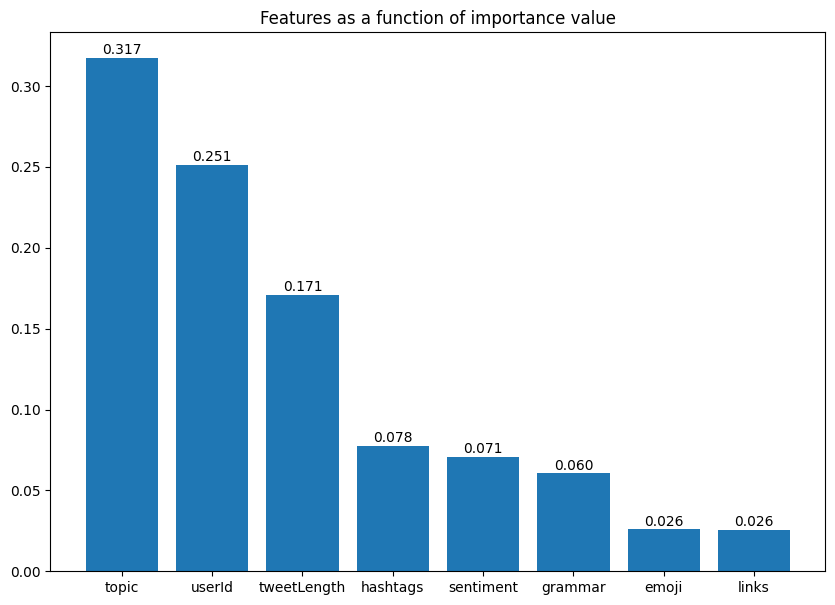

<Figure size 640x480 with 0 Axes>

In [8]:
# Get best features and columns
best_features = best_estimator.feature_importances_
feature_names = forest_train.columns

# Combine the best features with the columns
feature_importance_dict = dict(zip(forest_train, best_features))

# Sort values from max to min
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

features = []
values = []

# print features
for feature, importance in sorted_features:
    print(f"Feature: {feature}, Importance: {importance}")
    features.append(feature)
    values.append(importance)

# plot the features
plt.figure(figsize=(10, 7))
bars = plt.bar(features, values)
plt.bar_label(bars, padding= 0.5, fmt='%.3f', label_type='edge')

plt.title('Features as a function of importance value')
plt.show()
plt.savefig("graphs/feature_importance_nolang.png")

In [9]:
y_pred = best_estimator.predict(forest_test)

precision, recall = confusion_matrix(forest_true_test, y_pred)

print(f1_score(precision, recall))

0.8151260504201682
